## Wasserstein Generative Adversarial Neural Network
Code Adapted From: https://github.com/luslab/scRNAseq-WGAN-GP

In [1]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import copy
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
tf.set_random_seed(7)

In [3]:
os.getcwd()

'/home/akashr/Documents/CMU/sem_4/computational_genomics/project/02-710/datasets/hemberg_human_pancreas'

In [4]:
# if new model, change the following:
! rm -r models/003
! mkdir models/003
! mkdir models/003/tf_model/
! mkdir models/003/tf_outputs/
! mkdir models/003/tf_summaries/
model_id = '003'

## Data

In [5]:
input_matrix = pd.read_pickle('processed_datasets/2_merged_filtered_logRPKM_dataset.pkl')
# Random shuffle
input_matrix = input_matrix.values
input_matrix_copy = np.copy(input_matrix)

In [6]:
input_matrix.shape

(3067, 8259)

## Hyperparameters

In [7]:
# LEARNING PARAMS
n_train_steps = 10000
batch_size = 32
num_cells_train = 2700
num_cells_generate = 300
initial_run = True
model_to_use = "models/" + model_id +"/tf_model/"
tensorboard_summary_path = "models/" + model_id + "/tf_summaries/"
## Learning Rates
g_lrn_rate = 1e-4
g_beta1 = d_beta1 = 0.0
g_beta2 = d_beta2 = 0.9
d_lrn_rate = 1e-3

# INTIALIZERS
INIT_MODE = 'xavier' # or root6
## Gaussian
max_expr = np.max(input_matrix)
normal_mean = 0.0
normal_std = max_expr/10
## Poisson
poisson_lambda = 1
## Constant Initializer
constant = 0.1

# LEAKY RELU
l_relu_alpha = 0.2

# L2 REGULARIZER
scale = 0.8

# WASSERSTEIN GRADIENT PENALTY
LAMBDA = 10

# PHENOTYPES
phenotypes = ['cell_type', 'disease_condition', 'dataset']
exclude_cols = - len(phenotypes)
gex_size = input_matrix.shape[1] + exclude_cols # Number of genes

# GENERATOR
noise_input_size = 100
g_h1 = 512
g_h2 = 1024

# DISCRIMINATOR
d_h1 = 512
d_h2 = 256

# DISC-TO-GEN ITER RATIO
d2g_iter_ratio = 5

In [8]:
input_matrix = input_matrix[:, :exclude_cols]

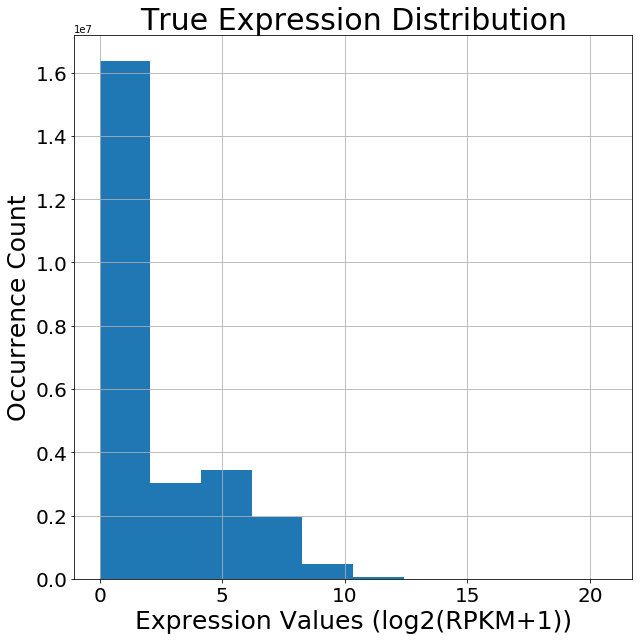

In [9]:
plt.rcParams["figure.figsize"] = (10,10)

gen_cells_hst = np.hstack(input_matrix)
plt.hist(gen_cells_hst) # arguments are passed to np.histogram
plt.title("True Expression Distribution", fontsize=30)
plt.xlabel("Expression Values (log2(RPKM+1))",fontsize=25)
plt.ylabel("Occurrence Count",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid()
plt.show()

In [10]:
input_matrix.shape

(3067, 8256)

## Latent Noise Vector
Includes poisson noise from count data and some extra gaussian noise

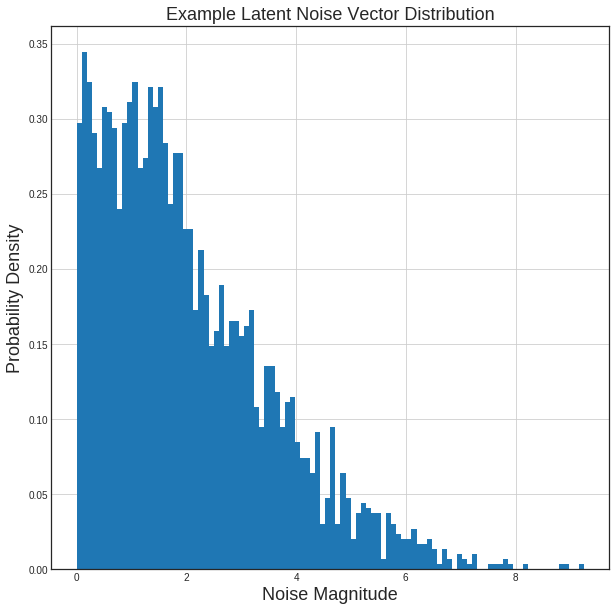

In [11]:
def noise_prior(batch_size, dim):
    gaussian_noise = np.random.normal(loc=normal_mean, scale=normal_std, size=(batch_size, dim))
    poisson_noise = np.random.poisson(lam=poisson_lambda, size=(batch_size, dim))
    return np.abs(gaussian_noise + poisson_noise)
      
example_noise_batch = noise_prior(32, 100)
example_noise_hist = np.hstack(numpy.ndarray.flatten(example_noise_batch))

plt.style.use('seaborn-white')
count, bins, ignored = plt.hist(example_noise_hist, bins=100, normed=True, edgecolor="none")
plt.title("Example Latent Noise Vector Distribution", fontsize=18)
plt.xlabel("Noise Magnitude", fontsize=18)
plt.ylabel("Probability Density", fontsize=18)
plt.grid()
plt.show()

In [12]:
def get_uniform_limit(h_1, h_0):
    b = np.sqrt(6)/np.sqrt(h_1 + h_0)
    return b

In [13]:
def get_xavier_stddev(h_1, h_0):
    return np.sqrt(2.0/(h_1 + h_0))

## Generator

In [14]:
def lrelu(x):
    return tf.maximum(x, l_relu_alpha * x)

# Latent vector Input
z = tf.placeholder(name="z", dtype=tf.float32, shape=(None, noise_input_size))

g_b1 = tf.get_variable("g_b1", 
                       [g_h1], 
                       initializer=tf.constant_initializer(constant))
g_b2 = tf.get_variable("g_b2", 
                           [g_h2], 
                           initializer=tf.constant_initializer(value=constant))
g_b3 = tf.get_variable("g_b3", 
                           [gex_size], 
                           initializer=tf.constant_initializer(value=constant))

if INIT_MODE is 'root6':
    # Fully Connected Hidden Layer 1
    unif_limit = get_uniform_limit(h_1=g_h1, h_0=noise_input_size)
    g_w1 = tf.get_variable("g_w1", 
                           [noise_input_size,g_h1],
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           )
    

    # # Fully Connected Hidden Layer 2
    unif_limit = get_uniform_limit(h_1=g_h2, h_0=g_h1)
    g_w2 = tf.get_variable("g_w2", 
                           [g_h1, g_h2], 
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           )
    

    # Output Layer
    unif_limit = get_uniform_limit(h_1=gex_size, h_0=g_h2)
    g_w3 = tf.get_variable("g_w3", 
                           [g_h2, gex_size],
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           regularizer=tf.contrib.layers.l2_regularizer(scale))

elif INIT_MODE is 'xavier':
    # Fully Connected Hidden Layer 1
    stddev = get_xavier_stddev(h_1=g_h1, h_0=noise_input_size)
    g_w1 = tf.get_variable("g_w1", 
                           [noise_input_size,g_h1],
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           )
    

    # # Fully Connected Hidden Layer 2
    stddev = get_xavier_stddev(h_1=g_h2, h_0=g_h1)
    g_w2 = tf.get_variable("g_w2", 
                           [g_h1, g_h2], 
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           )
    

    # Output Layer
    stddev = get_xavier_stddev(h_1=gex_size, h_0=g_h2)
    g_w3 = tf.get_variable("g_w3", 
                           [g_h2, gex_size],
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           )
    
g_params = [g_w1, g_b1, g_w2, g_b2, g_w3, g_b3]

def generator(z):
    g_y1 = lrelu(tf.matmul(z, g_w1) + g_b1)
    g_y2 = lrelu(tf.matmul(g_y1, g_w2) + g_b2)
    G = tf.nn.relu(tf.matmul(g_y2, g_w3) + g_b3)
    
    #tensorboard
    tf.summary.histogram('g_layer1/g_y1', g_y1)
    tf.summary.histogram('g_layer2/g_y2', g_y2)
    tf.summary.histogram('g_layer3/out', G)
    return G

## Discriminator / Critic

In [15]:
# Real or Fake Gene Expression Input
x = tf.placeholder(name='x', dtype=tf.float32, shape=(None, gex_size))

d_b1 = tf.get_variable("d_b1", 
                       [d_h1], 
                       initializer=tf.constant_initializer(value=constant))

d_b2 = tf.get_variable("d_b2", 
                       [d_h2], 
                       initializer=tf.constant_initializer(value=constant))

d_b3 = tf.get_variable("d_b3", 
                       [1], 
                       initializer=tf.constant_initializer(constant))

if INIT_MODE is 'root6':
    # Fully Connected Hidden Layer 1
    unif_limit = get_uniform_limit(h_1=d_h1, h_0=gex_size)
    d_w1 = tf.get_variable("d_w1", 
                           [gex_size,d_h1], 
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))


    # Fully Connected Hidden Layer 2 
    unif_limit = get_uniform_limit(h_1=d_h2, h_0=d_h1)
    d_w2 = tf.get_variable("d_w2", 
                           [d_h1, d_h2], 
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))

    # Output Layer
    unif_limit = get_uniform_limit(h_1=1, h_0=d_h2)
    d_w3 = tf.get_variable("d_w3", 
                           [d_h2, 1], 
                           initializer=tf.random_uniform_initializer(-unif_limit, unif_limit),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))

elif INIT_MODE is 'xavier':
    # Fully Connected Hidden Layer 1
    stddev = get_xavier_stddev(h_1=d_h1, h_0=gex_size)
    d_w1 = tf.get_variable("d_w1", 
                           [gex_size,d_h1], 
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))


    # Fully Connected Hidden Layer 2 
    unif_limit = get_xavier_stddev(h_1=d_h2, h_0=d_h1)
    d_w2 = tf.get_variable("d_w2", 
                           [d_h1, d_h2], 
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))

    # Output Layer
    unif_limit = get_xavier_stddev(h_1=1, h_0=d_h2)
    d_w3 = tf.get_variable("d_w3", 
                           [d_h2, 1], 
                           initializer=tf.random_normal_initializer(mean=normal_mean, stddev=stddev),
                           regularizer=tf.contrib.layers.l2_regularizer(scale=scale))

d_params = [d_w1, d_b1, d_w2, d_b2, d_w3, d_b3]

def getter(x): return x

def discriminator(x, get_output):
    d_y1 = lrelu(tf.matmul(x, d_w1) + d_b1)
    d_y2 = lrelu(tf.matmul(d_y1, d_w2) + d_b2)
    D = tf.matmul(d_y2, d_w3) + d_b3

    weights_d1 = tf.summary.histogram('d_layer1/d_w1_bar', d_w1)
    weights_d2 = tf.summary.histogram('d_layer2/d_w2_bar', d_w2)
    weights_d3 = tf.summary.histogram('d_layer3/d_w3_bar', d_w3)

    bias_d1 = tf.summary.histogram('d_layer1/d_b1', d_b1)
    bias_d2 = tf.summary.histogram('d_layer2/d_b2', d_b2)
    bias_d3 = tf.summary.histogram('d_layer3/d_b3', d_b3)

    tf.summary.histogram('d_layer1/d_y1', d_y1)
    tf.summary.histogram('d_layer2/d_y2', d_y2)
    tf.summary.histogram('d_layer3/D', D)
    
    res = tf.cond(get_output, lambda: getter(d_y2), lambda: getter(D))
    return res

Instructions for updating:
Use the retry module or similar alternatives.


In [16]:
# Outputs of each network that will be optimized through training
boo = tf.placeholder(name='boo', dtype=tf.bool, shape=())
G = generator(z)
D_real = discriminator(x, boo)
D_fake = discriminator(G, boo)

## Wasserstein Loss Functions

Wasserstein distance/objectives with added gradient penalty.

NB: Depending on data you may need to tune gradient penalty parameter lambda

In [17]:
obj_d = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) # Wasserstein Distance
obj_g = -tf.reduce_mean(D_fake)

alpha = tf.random_uniform(shape=[batch_size,gex_size],
                          minval=0.0,
                          maxval=1.0)

differences = D_fake - D_real
interpolates = D_real + (alpha*differences)
gradients = tf.gradients(discriminator(interpolates, boo), [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
gradient_penalty = tf.reduce_mean((slopes-1.)**2)
obj_d += LAMBDA * gradient_penalty

In [18]:
time_step = tf.placeholder(name='time_step', dtype=tf.int32)

# Discriminator Learning
d_batch = tf.Variable(0, trainable=False)
d_optimizer = tf.train.AdamOptimizer(learning_rate=d_lrn_rate, beta1=d_beta1, beta2=d_beta2)
opt_d = d_optimizer.minimize(obj_d, var_list=d_params)
d_grad = d_optimizer.compute_gradients(obj_d, var_list=d_params)

# Generator Learning
g_batch = tf.Variable(0, trainable=False)
g_optimizer =  tf.train.AdamOptimizer(learning_rate=g_lrn_rate, beta1=d_beta1, beta2=d_beta2)
opt_g = g_optimizer.minimize(obj_g, var_list=g_params)
g_grad = g_optimizer.compute_gradients(obj_g, var_list=g_params)

obj_d_summary = tf.summary.scalar('obj_d', obj_d)
obj_g_summary = tf.summary.scalar('obj_g', obj_g)
for i in d_grad:
    name = i[1]
    gradient = i[0]
    l2_norm = tf.reduce_mean(tf.nn.l2_normalize(gradient))
    l2_norm_grad_summary = tf.summary.scalar(name.name, l2_norm)


for i in g_grad:
    name = i[1]
    gradient = i[0]
    l2_norm = tf.reduce_mean(tf.nn.l2_normalize(gradient))
    l2_norm_grad_summary = tf.summary.scalar(name.name, l2_norm)
    
weights_g1 = tf.summary.histogram('layer1/g_w1', g_w1)
weights_g2 = tf.summary.histogram('layer2/g_w2', g_w2)
weights_g3 = tf.summary.histogram('layer3/g_w3', g_w3)

bias_g1 = tf.summary.histogram('layer1/g_b1', g_b1)
bias_g2 = tf.summary.histogram('layer2/g_b2', g_b2)
bias_g3 = tf.summary.histogram('layer3/g_b3', g_b3)

INFO:tensorflow:Summary name d_w1:0 is illegal; using d_w1_0 instead.
INFO:tensorflow:Summary name d_b1:0 is illegal; using d_b1_0 instead.
INFO:tensorflow:Summary name d_w2:0 is illegal; using d_w2_0 instead.
INFO:tensorflow:Summary name d_b2:0 is illegal; using d_b2_0 instead.
INFO:tensorflow:Summary name d_w3:0 is illegal; using d_w3_0 instead.
INFO:tensorflow:Summary name d_b3:0 is illegal; using d_b3_0 instead.
INFO:tensorflow:Summary name g_w1:0 is illegal; using g_w1_0 instead.
INFO:tensorflow:Summary name g_b1:0 is illegal; using g_b1_0 instead.
INFO:tensorflow:Summary name g_w2:0 is illegal; using g_w2_0 instead.
INFO:tensorflow:Summary name g_b2:0 is illegal; using g_b2_0 instead.
INFO:tensorflow:Summary name g_w3:0 is illegal; using g_w3_0 instead.
INFO:tensorflow:Summary name g_b3:0 is illegal; using g_b3_0 instead.


## Generate Cells every i-th iteration

In [19]:
def generate_cells(i):
    gen_cells = sess.run(G, {z : noise_prior(1, 100)})
    for cell in range(num_cells_generate):
        out_gen_temp = sess.run(G, {z : noise_prior(1, 100)})
        gen_cells = numpy.append(gen_cells, out_gen_temp, axis=0)
    print("Generated cells !")
    pd.DataFrame(gen_cells).to_pickle('models/' + model_id + '/tf_outputs/GEN_CELL_%s.pkl' %(i))

In [20]:
input_matrix_copy.shape

(3067, 8259)

## Training

In [ ]:
import time
start_time = time.time()
# Counts number of training steps
global_step = tf.Variable(0, name='global_step', trainable=False, dtype=tf.int32)

sess=tf.InteractiveSession()
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(tensorboard_summary_path, sess.graph)
saver = tf.train.Saver()
init = tf.global_variables_initializer().run()

if initial_run:
    print("Initial run")
    assign_step_zero = tf.assign(global_step, 0)
    init_step = sess.run(assign_step_zero)
    
if not initial_run:
    saver.restore(sess, model_to_use)

print("% done   Steps    Time(min)    d_loss    g_loss")
for i in range(n_train_steps):
    increment_global_step_op = tf.assign(global_step, global_step + 1)
    step = sess.run(increment_global_step_op)
    current_step = sess.run(global_step)
    
    # Randomly sample real gene expression vectors
    idx = np.random.randint(dtype=int, low=0, high=input_matrix.shape[0], size=batch_size)
    x_data = input_matrix[idx, :]
    
    # Generate latent vectors   
    noise = noise_prior(batch_size, noise_input_size)
    
    #train discriminator twice for every generator train
    for j in range(d2g_iter_ratio):
        d_loss, summary = sess.run([obj_d, merged], {boo: False, x : x_data, z : noise, time_step : current_step})
        train_writer.add_summary(summary, current_step)
        if i % 1000 == 0 and i > 0 and j == (d2g_iter_ratio - 1):
            x_data = input_matrix_copy[:, :exclude_cols]
            noise = noise_prior(x_data.shape[0], noise_input_size)
            trans_data = sess.run([D_real], {boo: True, x : x_data, z : noise, time_step : current_step})
            pd.DataFrame(trans_data[0]).to_csv('models/' + model_id + "/tf_outputs/disc_out_"+str(i)+'.csv', 
                                               columns=None, header=False, index=False, index_label=None, encoding="utf8")
            generate_cells(i=i)
    # train generator    
    g_loss = sess.run([obj_g], {boo: False, z : noise, time_step : current_step})
    
    # every 5 % save and print
    if (i / n_train_steps) in np.arange(0.0,1.0, step=0.05, dtype=float):
        time_taken = round((time.time() - start_time) / 60.0, 4)
        print(str(round(float(i)/n_train_steps, 4)) + "    " + str(current_step) + "    " +
             str(time_taken) + "  " + str(d_loss) + "  " + str(g_loss[0]))
        intermediate_save_path = saver.save(sess, model_to_use, global_step=current_step)

save_path = saver.save(sess, model_to_use)
print("Model saved in file: %s" % save_path)

print("Total time elapsed = --- %s hours ---" % ((time.time() - start_time)/3600.0))

Initial run
% done   Steps    Time(min)    d_loss    g_loss
0.0    1    0.1051  8.094239  -0.06260559
0.05    501    39.1645  8.072465  -0.060642086


In [ ]:
trans_data[0].shape

In [ ]:
input_matrix_copy[:, :].shape

In [ ]:
pd.DataFrame(input_matrix_copy).to_pickle('002_input_matrix.pkl')

In [ ]:
gen_cell_final = generate_cells(i='END')

### Generate cells after training

In [ ]:
gen_cell_final

In [ ]:
temp = pd.read_pickle('GEN_CELL_14000.pkl')

In [ ]:
temp.shape

In [ ]:
np.mean(temp.values) - np.mean(input_matrix)

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
gen_cells_hst = np.hstack(temp.values)
plt.hist(input_unprocessed_hst) # arguments are passed to np.histogram
plt.title("Generated Expression Distribution", fontsize=30)
plt.xlabel("Expression Values (log2(RPKM+1))",fontsize=25)
plt.ylabel("Occurrence Count",fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)
plt.grid()
plt.show()

Looks like input distribution

In [ ]:
def get_PCA_components(n_comp, arr):
    pca = PCA(n_components=n_comp)
    pca.fit(arr)
    pcomps = pca.fit_transform(arr)
    return pcomps, pca.explained_variance_ratio_ 

In [ ]:
def plot_2D_phenotype(components, option, phenotypes, phenotype_dict, title, var_ratio=None, ):
    # option can be cell_type, disease_condition or dataset
    fig = plt.figure()
    #matplotlib.rcParams.update({'font.size':12})
    plt.rcParams["figure.figsize"] = (10,10)
    legend_set =  sorted(phenotype_dict.items(), key=operator.itemgetter(1))
    if option == 'cell_type':
        colors = ['Red', 'Blue', 'Black', 'Yellow']
        pheno_label = 'cell_type'
    
    elif option == 'disease_type':
        colors = ['Red', 'Blue']
        pheno_label = 'disease_conditon'
        
    else:
        colors = ['Red', 'Blue']
        pheno_label = 'dataset'
        
    for k, col in zip(legend_set, colors):
        plot_idxs = np.where(phenotypes == k[1])
        plt.scatter(components[plot_idxs,0], components[plot_idxs, 1], c=col, alpha=0.5)
    
    if var_ratio is not None:
        plt.xlabel('Component 1 (Variance = %s %%)' %(var_ratio[0] * 100),fontsize=25)
        plt.ylabel('Component 2 (Variance = %s %%)' %(var_ratio[1] * 100),fontsize=25)
    else:
        plt.xlabel('t-SNE 1 ',fontsize=25)
        plt.ylabel('t-SNE 2 ',fontsize=25)
        
    
    lgnd = plt.legend((i[0] for i in legend_set), prop={'size': 20}, loc=2)
    
    for i in range(len(lgnd.legendHandles)):
        lgnd.legendHandles[i]._sizes = [160]
     
    plt.title(title,fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    
    plt.show()

In [ ]:
dataset_dict = {'E-MTAB-5061': 1, 'GSE81608': 2}
cell_type_dict = {'alpha cell': 0, 
                    'beta cell': 1,
                    'delta cell': 2,
                    'gamma cell': 3}
dis_cond_dict = {'normal': 0 , 'type II diabetes mellitus' : 1}

## Dimensionality Red of Discriminator Output

In [ ]:
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import operator

In [ ]:
trans_data[0].shape

In [ ]:
# tsne with 2 comps on the reduced data
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=1000)
tsne_components = tsne.fit_transform(trans_data[0])

In [ ]:
plot_2D_phenotype(components=tsne_components, 
                   option='dataset',
                   phenotypes=pheno[:, 2], 
                   phenotype_dict=dataset_dict,
                   var_ratio=None, 
                   title='Discriminator Activation + t-SNE')

In [ ]:
plot_2D_phenotype(components=tsne_components, 
                   option='disease_condition',
                   phenotypes=pheno[:, 1], 
                   phenotype_dict=dis_cond_dict,
                   var_ratio=None, 
                   title='Discriminator Activation + t-SNE')

In [ ]:
# plot_2D_phenotype(components=tsne_components, 
#                    option='cell_type',
#                    phenotypes=pheno[:, 0], 
#                    phenotype_dict=cell_type_dict,
#                    var_ratio=None, 
#                    title='Discriminator Activation + t-SNE')

fig = plt.figure()
plt.rcParams["figure.figsize"] = (15,15)
legend_set =  sorted(cell_type_dict.items(), key=operator.itemgetter(1))

colors = ['Red', 'Blue', 'Black', 'Yellow']
pheno_label = 'cell_type'

for k, col in zip(legend_set, colors):
    print(k[0])
    plot_idxs = np.where(pheno[:,0] == k[1])
    plt.scatter(tsne_components[plot_idxs,0], tsne_components[plot_idxs, 1], c=col, alpha=0.5)


plt.xlabel('t-SNE 1 ',fontsize=25)
plt.ylabel('t-SNE 2 ',fontsize=25)


lgnd = plt.legend((i[0] for i in legend_set),loc=3, prop={'size': 20})


# for i in range(len(lgnd.legendHandles)):
#     lgnd.legendHandles[i]._sizes = [160]

plt.title('Discriminator Activation + t-SNE',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)

plt.show()

In [ ]:
princ_comp, var_ratio = get_PCA_components(n_comp=2, arr=trans_data[0])

In [ ]:
plot_2D_phenotype(components=princ_comp, 
                   option='cell_type',
                   phenotypes=pheno[:, 0], 
                   phenotype_dict=cell_type_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on 200-dim output of 2nd hidden layer of Discriminator')

In [ ]:
plot_2D_phenotype(components=princ_comp, 
                   option='disease_condition',
                   phenotypes=pheno[:, 1], 
                   phenotype_dict=dis_cond_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on 200-dim output of 2nd hidden layer of Discriminator')

In [ ]:
plot_2D_phenotype(components=princ_comp, 
                   option='dataset',
                   phenotypes=pheno[:, 2], 
                   phenotype_dict=dataset_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on 200-dim output of 2nd hidden layer of Discriminator')

In [ ]:
pd.DataFrame(pheno).to_pickle('002_pheno.pkl')